# Uncertainty estimation

Test the second hypothesis that IT regime has bring down not just the inflation persistance and average inflation, but also the inflation uncertainty, measured by the conditional volatilty from GARCH models. 

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import iqr, norm
import statsmodels.stats.api as sms
import arch 
import pmdarima.arima as pm
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsap 
from statsmodels.tsa.stattools import adfuller

# Recursive OLS residuals
from statsmodels.stats.diagnostic import recursive_olsresiduals
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import chow_test
from scipy import stats
import arch

import warnings
warnings.filterwarnings("ignore")
np.random.seed(432)

## Data loading and preprocessing

In [2]:
inf1 = pd.read_csv('output/inflation_SeasAdj.csv', delimiter=';')
inf1.index = pd.to_datetime(inf1.date)
inf1 = inf1.drop("date", axis = 1)
# inf1.head()

In [131]:
# inf1.v_cpi.loc['1992-01-01':'2021-12-01'].plot()

In [79]:
simdf = inf1.loc['1992-01-01':'2021-12-01']
predf = simdf.loc['1992-01-01':'2004-12-01']
itdf  = simdf.loc['2005-01-01':'2021-12-01']

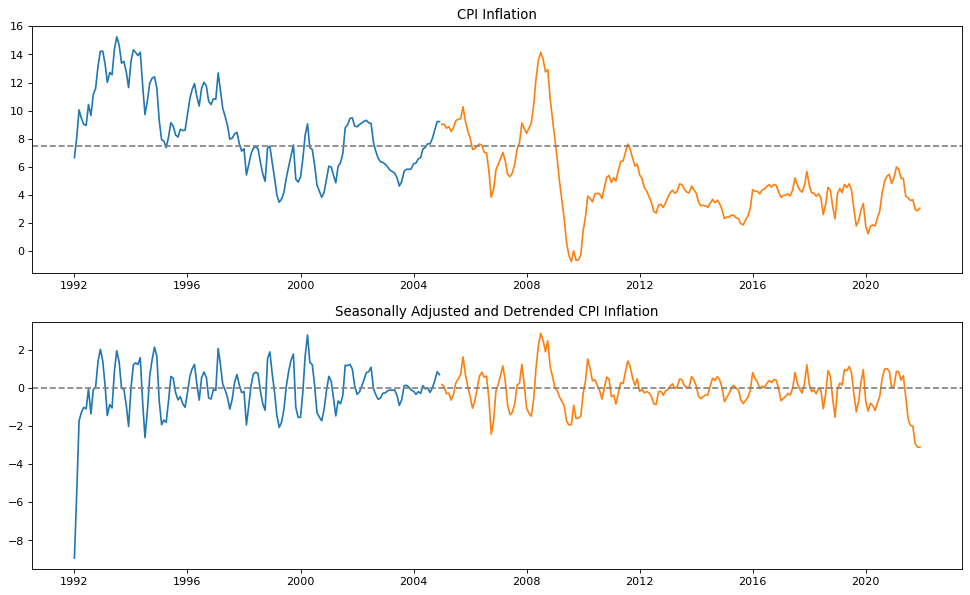

In [80]:
# Ploting the data
fig, axes = plt.subplots(2, 1, figsize=(15,9), dpi= 80)

axes[0].plot(predf['v_cpi'])
axes[0].plot(itdf['v_cpi'])
axes[0].set_title('CPI Inflation')
axes[0].axhline(y=np.mean(inf1['v_cpi']), color='grey', linestyle='--')

axes[1].plot(predf['inf_seasAdj'])
axes[1].plot(itdf['inf_seasAdj'])
axes[1].set_title('Seasonally Adjusted and Detrended CPI Inflation')
axes[1].axhline(y=0, color='grey', linestyle='--')

plt.show()


Controls

In [177]:
from fredapi import Fred
fred = Fred(api_key='ca6ea25f72db47e2d070a76b7e9e639b')
CorePCE = fred.get_series('PCEPILFE')
PCE = fred.get_series('PCEPI')
CpiUS = fred.get_series('CPIAUCSL')
Pet = fred.get_series('WTISPLC')

controls = pd.DataFrame()
controls['pce'] = PCE.pct_change(12)*100
controls['core_pce'] = CorePCE.pct_change(12)*100
controls['cpiUS'] = CpiUS.pct_change(12)*100
controls['pet'] = Pet.pct_change(12)*100

cont = controls.loc['1992-01-01':'2021-12-01']
# precont = controls.loc['1992-01-01':'2004-12-01']
# itcont  = controls.loc['2005-01-01':'2021-12-01']

# cont.head()

In [178]:
food = pd.read_csv('data/13072022/Food_price_indices_data_jul825.csv', delimiter=';')
food.index = pd.to_datetime(food.Date)#, format='%d/%m/%Y')
food = food.drop("Date", axis = 1)
cont['fao_Index'] = food['fao_Index'].pct_change(12)*100

In [187]:
other_gt = pd.read_csv('data/13072022/other_gt.csv', delimiter=';')
other_gt.index = pd.to_datetime(other_gt.Date, format='%d/%m/%Y')
other_gt = other_gt.drop("Date", axis = 1)
other_gt['ner_gt'] = other_gt['ner_gt'].pct_change(12)*100
other_gt['omas_mn'] = other_gt['omas_mn'].pct_change(12)*100
other_gt['emision'] = other_gt['emision'].pct_change(12)*100
cont['ner_gt'] = other_gt['ner_gt'].loc['1992-01-01':'2021-12-01']
cont['omas_mn'] = other_gt['omas_mn'].loc['1992-01-01':'2021-12-01']
cont['emision'] = other_gt['emision'].loc['1992-01-01':'2021-12-01']

cont2 = cont.dropna()

In [191]:
# cont2.head()

In [180]:
# cont = controls.loc['1992-01-01':'2021-12-01']
precont = cont.loc['1992-01-01':'2004-12-01']
itcont  = cont.loc['2005-01-01':'2021-12-01']
cont.to_csv('output/controls.csv')

## Modeling

### GARCH(1,1)


$\pi_t = \sigma_t e_t, e_t \sim iid N(0,1)$<br>
$\sigma_t^2 = \omega + \alpha \pi_{t-1}^2 + \beta \sigma_{t-1}^2$

#### Seasonally Adjusted Inflation

In [5]:
# GARCH(1,1)
garch = arch.arch_model(simdf['inf_seasAdj'], p=1, q=1, o=0, mean='zero', rescale=False, dist='gaussian', vol='garch')
res = garch.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:            inf_seasAdj   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:               -421.268
Distribution:                  Normal   AIC:                           848.536
Method:            Maximum Likelihood   BIC:                           860.093
                                        No. Observations:                  348
Date:                Thu, Jul 14 2022   Df Residuals:                      348
Time:                        09:30:37   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0216  1.523e-02      1.419      0.156 [-8.240e-03,5.145e-02]
alpha[1]       0.2102  6.453e-02      3.258  1.121e-03    [8.378e-02,  0.337]
beta[1]        0.7803  7.327e-02     10.649  1.770e-26      [  0.637,  0.924]
=============================================================================

Covariance estimator: robust
"""

In [6]:
# Period averages and differences
ITVolMean = res.conditional_volatility.loc['2005-01-01':].mean()
PreVolMean = res.conditional_volatility.loc[:'2004-12-01'].mean()
print('difference:', PreVolMean - ITVolMean)

difference: 0.1963539973290893


Mean difference test

In [7]:
# Test de diferencia de medias std
from scipy import stats
t_check=stats.ttest_ind(res.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        res.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre IT mean is statistically different from IT mean')
    print(t_check[1])

pre IT mean is statistically different from IT mean
6.123588051161115e-07


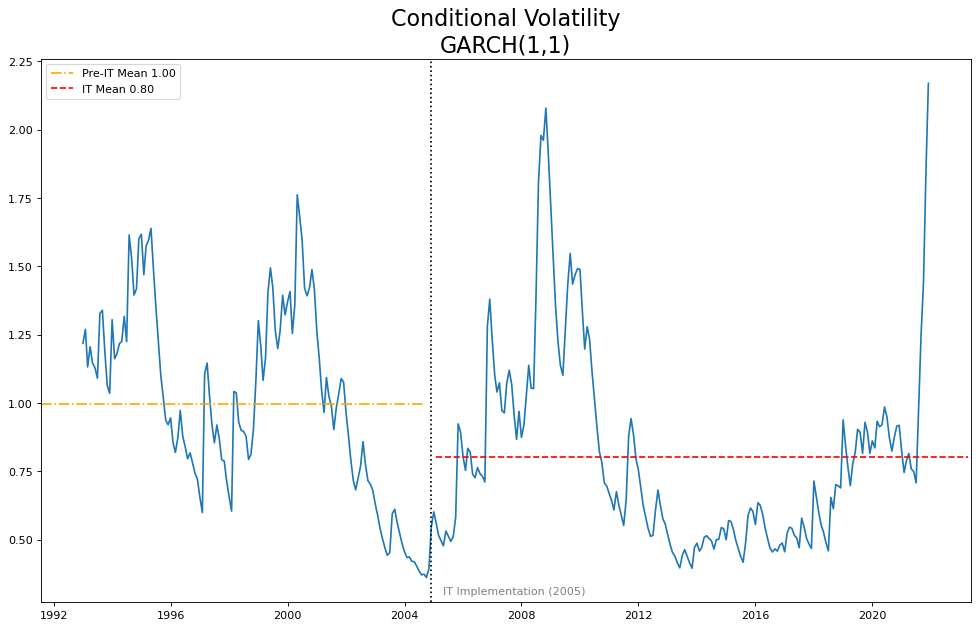

In [8]:
# pd.to_datetime(df_m.index[20])
x0 = (simdf.index.get_loc('1993-01-01'))/len(simdf.index)
x1 = (simdf.index.get_loc('2004-12-01'))/len(simdf.index)
x2 = (simdf.index.get_loc('2005-05-01'))/len(simdf.index)
x3 = (simdf.index.get_loc('2021-12-01'))/len(simdf.index)

plt.figure(figsize=(15,9), dpi= 80)
plt.plot(res.conditional_volatility)
plt.title('Conditional Volatility\nGARCH(1,1)', fontsize=20)
plt.axvline(x=pd.to_datetime('2004-12-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.30, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMean, color='orange', linestyle='-.', label = 'Pre-IT Mean {:.2f}'.format(PreVolMean))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMean, color='red', linestyle='--', label = 'IT Mean {:.2f}'.format(ITVolMean))
plt.legend()
# plt.text(pd.to_datetime('1993-01-01'),PreVolMean-0.07, 'Pre-IT Mean {:.2f}'.format(PreVolMean), fontsize=10)
# plt.text(pd.to_datetime('2019-06-01'),ITVolMean-0.07, 'IT Mean {:.2f}'.format(ITVolMean), fontsize=10)

#### Observed Inflation


In [82]:
# GARCH(1,1)
garch2 = arch.arch_model(simdf['v_cpi'], p=1, q=1, mean='ARX', rescale=False, dist='StudentsT', vol='garch')
res2 = garch2.fit(disp=False)
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                        v_cpi   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -780.092
Distribution:      Standardized Student's t   AIC:                           1570.18
Method:                  Maximum Likelihood   BIC:                           1589.62
                                              No. Observations:                  360
Date:                      Thu, Jul 14 2022   Df Residuals:                      359
Time:                              10:26:56   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          4.6651      0.563      8.291  1.122e-16 [  3.562,  5.768]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3993      0.194      2.054  4.002e-02 [1.819e-02,  0.780]
alpha[1]       0.9708      0.339      2.861  4.220e-03   [  0.306,  1.636]
beta[1]    9.4581e-21      0.259  3.653e-20      1.000   [ -0.507,  0.507]
                                Distribution                                
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
nu           371.6858    119.378      3.114  1.849e-03 [1.377e+02,6.057e+02]
============================================================================

Covariance estimator: robust
"""

In [83]:

# Period averages and differences
ITVolMean2b = res2.conditional_volatility.loc['2005-01-01':].mean()
PreVolMean2b= res2.conditional_volatility.loc[:'2004-12-01'].mean()
print('difference:', PreVolMean2b - ITVolMean2b)

difference: 1.9342001153114379


Mean difference test

In [84]:
# Test de diferencia de medias std
from scipy import stats
t_check=stats.ttest_ind(res2.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        res2.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre IT mean is statistically different from IT mean')
    print(t_check[1])

pre IT mean is statistically different from IT mean
8.366150496357277e-16


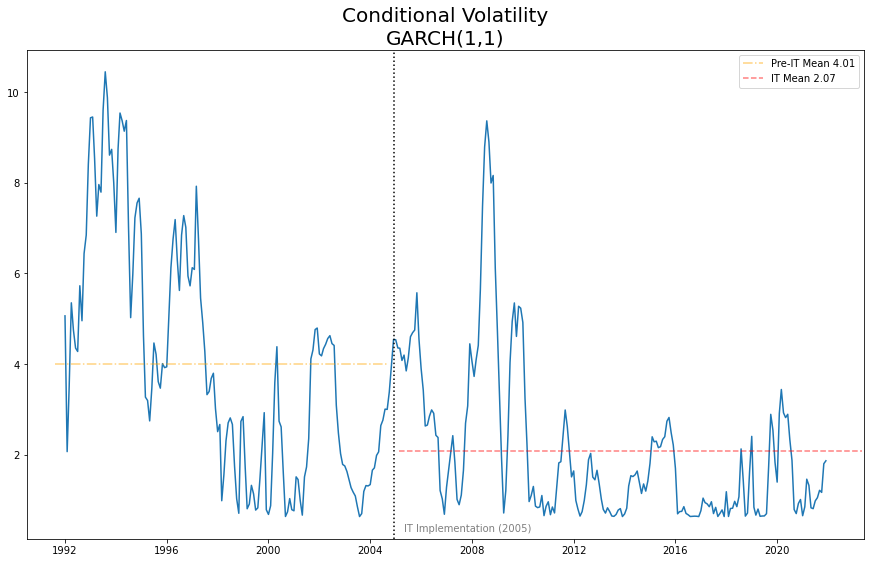

In [85]:
# pd.to_datetime(df_m.index[20])
x0 = (simdf.index.get_loc('1993-01-01'))/len(simdf.index)
x1 = (simdf.index.get_loc('2004-12-01'))/len(simdf.index)
x2 = (simdf.index.get_loc('2005-05-01'))/len(simdf.index)
x3 = (simdf.index.get_loc('2021-12-01'))/len(simdf.index)
plt.figure(figsize=(15,9))
plt.plot(res2.conditional_volatility)
# res2.conditional_volatility.rolling(24).mean().plot(figsize=(15,9))
plt.title('Conditional Volatility\nGARCH(1,1)', fontsize=20)
plt.axvline(x=pd.to_datetime('2004-12-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.30, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMean2b, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean2b))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMean2b, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean2b))
plt.legend()

### ARMA(p,q) / GARCH(p,q) model

$\pi_t = \mu_t + \epsilon_t$<br>
$\epsilon_t = \sigma_t e_t$ where $e_t \sim idd N(0,1)$<br>
$\mu_t = \mu_0 + \sum_{j=1}^{p_A} \phi_j(\pi_{t-i} - \mu) + \sum_{j=1}^{q_A}\theta_i \epsilon_{t-1}$ (ARMA Process)<br>
$\sigma_t = \omega + \sum_{j=1}^{p_G} \alpha_j \epsilon_{t-1}^2 + \sum_{j=1}^{q_G} \beta_j \sigma_{t-1}^2$ (GARCH Process) 

#### Seasonally adjusted Inflation

ARMA Process Fit

In [13]:
arma1 = pm.auto_arima(simdf['inf_seasAdj'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=12,              # frequency of series
                      d=0,           # let model determine 'd'              
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

arma1.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=657.735, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=956.582, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=725.183, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=719.863, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=633.040, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=633.113, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=634.909, Time=0.87 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=634.472, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=651.996, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=633.711, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=623.470, Time=0.76 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=608.589, Time=1.07 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=632.139, Time=0.25 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=609.607, Time=1.12 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=596.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  348
Model:               SARIMAX(2, 0, 4)   Log Likelihood                -289.916
Date:                Thu, 14 Jul 2022   AIC                            593.833
Time:                        09:30:56   BIC                            620.798
Sample:                             0   HQIC                           604.568
                                - 348                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2716      0.021     59.394      0.000       1.230       1.314
ar.L2         -0.9314      0.018    -51.923      0.000      -0.967      -0.896
ma.L1         -0.3162      0.048     -6.607      0.000      -0.410      -0.222
ma.L2          0.2624      0.050      5.259      0.000       0.165       0.360
ma.L3          0.4996      0.051      9.728      0.000       0.399       0.600
ma.L4          0.2109      0.052      4.018      0.000       0.108       0.314
sigma2         0.3070      0.020     15.641      0.000       0.269       0.345
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                34.59
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARMA Process

In [14]:
arma_AP2 = ARIMA(endog=simdf['inf_seasAdj'], order=(2,0,4)).fit()
arma_AP2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            inf_seasAdj   No. Observations:                  348
Model:                     ARMA(2, 4)   Log Likelihood                -289.798
Method:                       css-mle   S.D. of innovations              0.554
Date:                Thu, 14 Jul 2022   AIC                            595.596
Time:                        09:30:57   BIC                            626.413
Sample:                    01-01-1993   HQIC                           607.865
                         - 12-01-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0362      0.074     -0.487      0.626      -0.182       0.110
ar.L1.inf_seasAdj     1.2717      0.026     49.031      0.000       1.221       1.323
ar.L2.inf_seasAdj    -0.9317      0.026    -35.999      0.000      -0.982      -0.881
ma.L1.inf_seasAdj    -0.3169      0.060     -5.278      0.000      -0.435      -0.199
ma.L2.inf_seasAdj     0.2623      0.048      5.515      0.000       0.169       0.356
ma.L3.inf_seasAdj     0.4996      0.046     10.879      0.000       0.410       0.590
ma.L4.inf_seasAdj     0.2104      0.056      3.773      0.000       0.101       0.320
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6825           -0.7794j            1.0360           -0.1355
AR.2            0.6825           +0.7794j            1.0360            0.1355
MA.1            0.5980           -0.8430j            1.0336           -0.1518
MA.2            0.5980           +0.8430j            1.0336            0.1518
MA.3           -1.7851           -1.1232j            2.1090           -0.4106
MA.4           -1.7851           +1.1232j            2.1090            0.4106
-----------------------------------------------------------------------------
"""

GARCH Process

In [15]:
garch_AP2 = arch.arch_model(arma_AP2.resid, p=2, q=4, o=0, dist='gaussian', mean='zero', rescale=False ).fit(disp=False)
garch_AP2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:               -264.955
Distribution:                  Normal   AIC:                           543.911
Method:            Maximum Likelihood   BIC:                           570.876
                                        No. Observations:                  348
Date:                Thu, Jul 14 2022   Df Residuals:                      348
Time:                        09:30:57   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0103  1.896e-02      0.544      0.586 [-2.685e-02,4.749e-02]
alpha[1]       0.2663      0.170      1.569      0.117   [-6.641e-02,  0.599]
alpha[2]       0.0000      0.949      0.000      1.000      [ -1.861,  1.861]
beta[1]        0.0000      3.179      0.000      1.000      [ -6.230,  6.230]
beta[2]        0.0000      1.268      0.000      1.000      [ -2.485,  2.485]
beta[3]        0.4103      0.870      0.472      0.637      [ -1.295,  2.115]
beta[4]        0.3085      2.011      0.153      0.878      [ -3.632,  4.249]
=============================================================================

Covariance estimator: robust
"""

Estimators

In [16]:
mu_t2 = arma_AP2.predict(start=0,end=len(simdf[['inf_seasAdj']])-1)
eps_t2 = arma_AP2.resid
gamma_t2 = garch_AP2.conditional_volatility

ITVolMeanb2 = gamma_t2.loc['2005-01-01':].mean()
PreVolMeanb2 = gamma_t2.loc[:'2004-12-01'].mean()

Mean difference test

In [17]:
# Test de diferencia de medias std
from scipy import stats
t_check=stats.ttest_ind(garch_AP2.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        garch_AP2.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre_mean different from it_mean')
    print(t_check)

pre_mean different from it_mean
Ttest_indResult(statistic=-8.664960876113318, pvalue=1.760931072631496e-16)


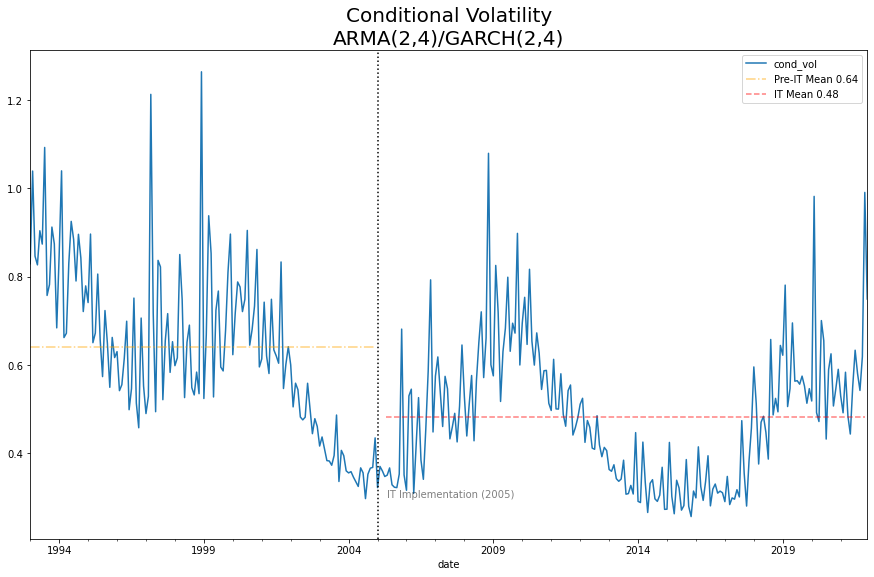

In [18]:
gamma_t2.plot(figsize=(15,9))
plt.title('Conditional Volatility\nARMA(2,4)/GARCH(2,4)', fontsize=20)
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.30, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMeanb2, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMeanb2))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMeanb2, color='red', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMeanb2))
plt.legend()
# plt.text(pd.to_datetime('1993-01-01'),PreVolMeanb2-0.07, 'Pre-IT Mean {:.2f}'.format(PreVolMeanb2), fontsize=10)
# plt.text(pd.to_datetime('2019-06-01'),ITVolMeanb2-0.07, 'IT Mean {:.2f}'.format(ITVolMeanb2), fontsize=10)

In [19]:
# forcCPI2 = mu_t2 + gamma_t2
# forcCPI2.plot(figsize=(15,9), label='ARMA(2,4)/GARCH(2,4)')
# # mu_t2.plot(figsize=(15,9), label='ARMA(2,4)')
# simdf['inf_seasAdj'].plot(figsize=(15,9), label='Observed')
# # mu_t.plot(figsize=(15,9), label='ARMA(1,1)')
# # gamma_t.plot(figsize=(15,9), label='GARCH(1,1)')
# plt.legend(loc='best', fontsize=15)
# plt.title('Forecasted CPI', fontsize=20)


#### Observed Inflation

ARMA Process Fit

In [20]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model1 = pm.auto_arima(simdf[['v_cpi']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=12,              # frequency of series
                      d=0,           # let model determine 'd'              
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model1.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=757.481, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2357.315, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=759.258, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=759.248, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.89 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=752.745, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1376.338, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=803.486, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=754.057, Time=0.41 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=754.099, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1804.317, Time=0.03 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  348
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -372.372
Date:                Thu, 14 Jul 2022   AIC                            752.745
Time:                        09:31:04   BIC                            768.154
Sample:                             0   HQIC                           758.880
                                - 348                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2670      0.124      2.150      0.032       0.024       0.510
ar.L1          0.9599      0.014     67.988      0.000       0.932       0.988
ma.L1          0.3973      0.049      8.038      0.000       0.300       0.494
sigma2         0.4929      0.028     17.304      0.000       0.437       0.549
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                38.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARMA process

In [21]:
arma_AP = ARIMA(endog=simdf[['v_cpi']], order=(1,0,1)).fit()
arma_AP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  v_cpi   No. Observations:                  348
Model:                     ARMA(1, 1)   Log Likelihood                -372.372
Method:                       css-mle   S.D. of innovations              0.702
Date:                Thu, 14 Jul 2022   AIC                            752.745
Time:                        09:31:04   BIC                            768.154
Sample:                    01-01-1993   HQIC                           758.880
                         - 12-01-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.6578      1.233      5.400      0.000       4.241       9.074
ar.L1.v_cpi     0.9599      0.016     59.964      0.000       0.929       0.991
ma.L1.v_cpi     0.3973      0.048      8.244      0.000       0.303       0.492
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0418           +0.0000j            1.0418            0.0000
MA.1           -2.5170           +0.0000j            2.5170            0.5000
-----------------------------------------------------------------------------
"""

GARCH process

In [22]:
garch_AP=arch.arch_model(arma_AP.resid, p=1, q=1, o=0, dist='gaussian', mean='zero', rescale=False ).fit(disp=False)
garch_AP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:               -354.773
Distribution:                  Normal   AIC:                           715.546
Method:            Maximum Likelihood   BIC:                           727.103
                                        No. Observations:                  348
Date:                Thu, Jul 14 2022   Df Residuals:                      348
Time:                        09:31:05   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0111  6.030e-03      1.847  6.478e-02 [-6.826e-04,2.295e-02]
alpha[1]       0.0924  2.359e-02      3.918  8.929e-05    [4.620e-02,  0.139]
beta[1]        0.8776  2.084e-02     42.109      0.000      [  0.837,  0.918]
=============================================================================

Covariance estimator: robust
"""

Estimators

In [23]:
mu_t = arma_AP.predict(start=0,end=len(simdf[['v_cpi']])-1)
eps_t = arma_AP.resid
gamma_t = garch_AP.conditional_volatility

ITVolMeanb = gamma_t.loc['2005-01-01':].mean()
PreVolMeanb = gamma_t.loc[:'2004-12-01'].mean()

Mean difference test

In [24]:
# Test de diferencia de medias std
from scipy import stats
t_check=stats.ttest_ind(garch_AP.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        garch_AP.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre IT mean is statistically different from IT mean')
    print(t_check[1])

pre IT mean is statistically different from IT mean
7.859322894524683e-18


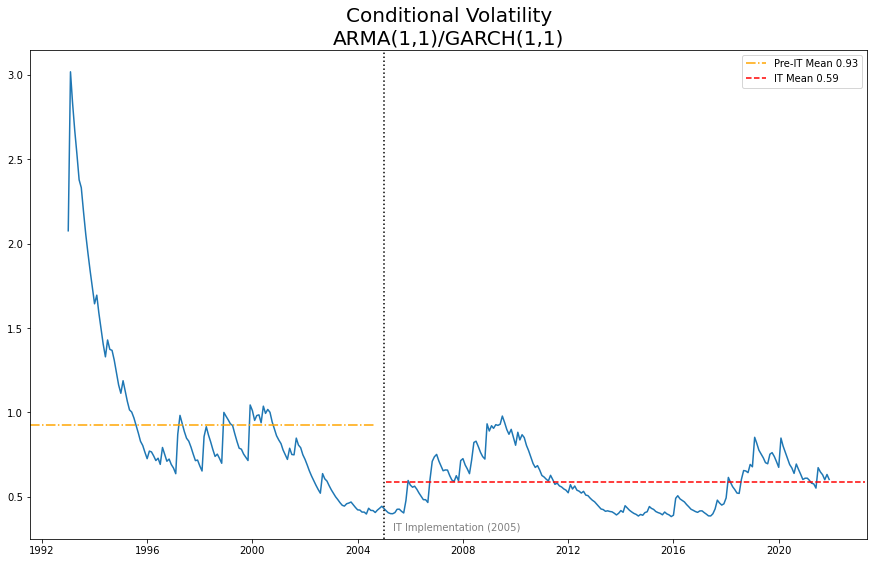

In [25]:
plt.figure(figsize=(15,9))
plt.plot(gamma_t)
plt.title('Conditional Volatility\nARMA(1,1)/GARCH(1,1)', fontsize=20)
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.30, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMeanb, color='orange', linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMeanb))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMeanb, color='r', linestyle='--', label='IT Mean {:.2f}'.format(ITVolMeanb))
plt.legend()
# plt.text(pd.to_datetime('1993-01-01'),PreVolMeanb-0.07, 'Pre-IT Mean {:.2f}'.format(PreVolMeanb), fontsize=10)
# plt.text(pd.to_datetime('2019-06-01'),ITVolMeanb-0.07, 'IT Mean {:.2f}'.format(ITVolMeanb), fontsize=10)

In [26]:
# forcCPI = mu_t + gamma_t
# forcCPI.plot(figsize=(15,9), label='ARMA(1,1)/GARCH(1,1)')
# simdf['v_cpi'].plot(figsize=(15,9), label='Observed')
# # mu_t.plot(figsize=(15,9), label='ARMA(1,1)')
# # gamma_t.plot(figsize=(15,9), label='GARCH(1,1)')
# plt.legend(loc='best', fontsize=15)
# plt.title('Forecasted CPI', fontsize=20)


## Volatility measures graph

In [27]:
x0 = (simdf.index.get_loc('1993-01-01'))/len(simdf.index)
x1 = (simdf.index.get_loc('2004-12-01'))/len(simdf.index)
x2 = (simdf.index.get_loc('2005-01-01'))/len(simdf.index)
x3 = (simdf.index.get_loc('2021-12-01'))/len(simdf.index)

Text(0.01, -0.15, 'All differences between means are statistically significant at the 1% level')

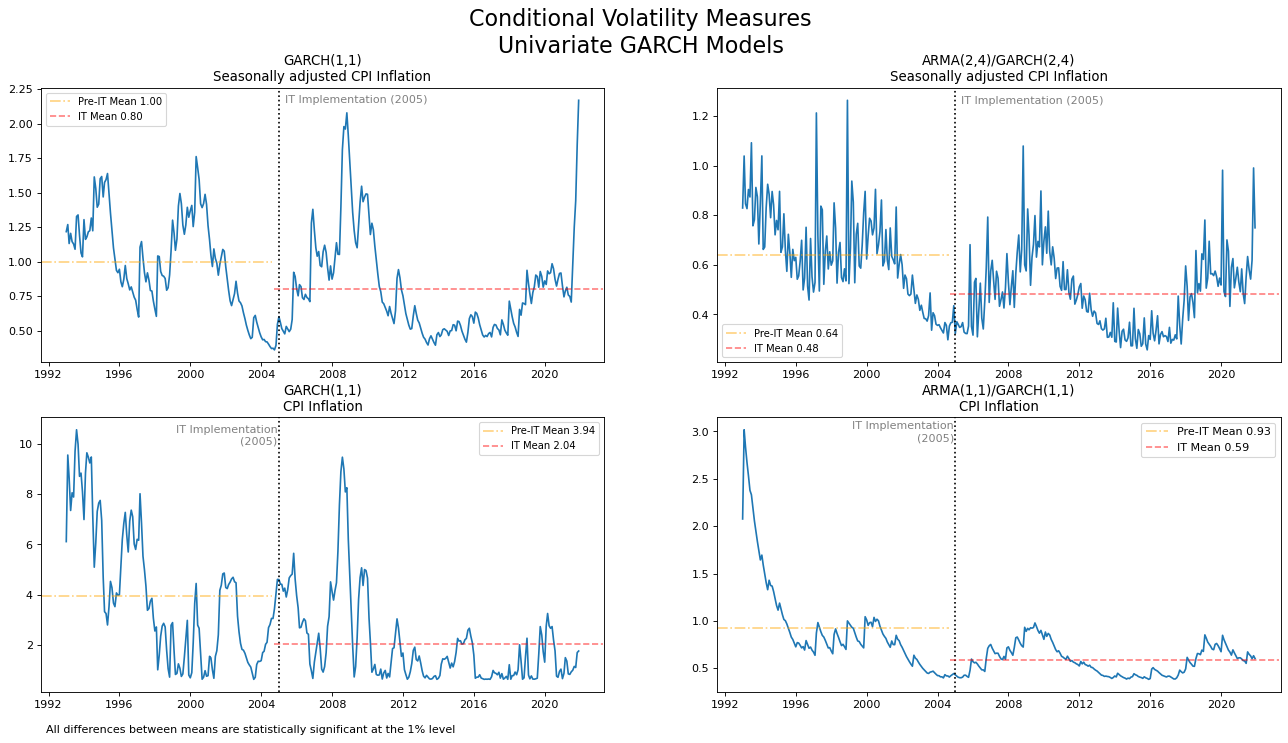

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)

plt.suptitle('Conditional Volatility Measures\nUnivariate GARCH Models', fontsize=20)

# GARCH(1,1) on Seasonally Adjusted CPI Inflation
axes[0,0].plot(res.conditional_volatility)
axes[0,0].set_title('GARCH(1,1)\nSeasonally adjusted CPI Inflation', fontsize=12)
axes[0,0].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
axes[0,0].text(pd.to_datetime('2005-05-01'), 2.15, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
axes[0,0].axhline(xmin=x0, xmax=x1, y=PreVolMean, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean))
axes[0,0].axhline(xmin=x2, xmax=x3, y=ITVolMean, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean))
axes[0,0].legend(loc='best', fontsize=9)
# GARCH(1,1) on CPI Inflation
axes[1,0].plot(res2.conditional_volatility)
axes[1,0].set_title('GARCH(1,1)\nCPI Inflation', fontsize=12)
axes[1,0].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
axes[1,0].text(pd.to_datetime('2004-12-01'),10.0, 'IT Implementation\n(2005)', fontsize=10, alpha=0.5, ha='right')
axes[1,0].axhline(xmin=x0, xmax=x1, y=PreVolMean2b, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean2b))
axes[1,0].axhline(xmin=x2, xmax=x3, y=ITVolMean2b, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean2b))
axes[1,0].legend(loc='best', fontsize=9)
# ARMA(p,q) / GARCH(p,q) model on Seasonally Adjusted CPI Inflation
axes[0,1].plot(gamma_t2)
axes[0,1].set_title('ARMA(2,4)/GARCH(2,4)\nSeasonally adjusted CPI Inflation', fontsize=12)
axes[0,1].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
axes[0,1].text(pd.to_datetime('2005-05-01'),1.25, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
axes[0,1].axhline(xmin=x0, xmax=x1, y=PreVolMeanb2, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMeanb2))
axes[0,1].axhline(xmin=x2, xmax=x3, y=ITVolMeanb2, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMeanb2))
axes[0,1].legend(loc='lower left', fontsize=9)
# ARMA(p,q) / GARCH(p,q) model on CPI Inflation
axes[1,1].plot(gamma_t)
axes[1,1].set_title('ARMA(1,1)/GARCH(1,1)\nCPI Inflation', fontsize=12)
axes[1,1].axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
axes[1,1].text(pd.to_datetime('2004-12-01'),2.90, 'IT Implementation\n(2005)', fontsize=10, alpha=0.5, ha='right')
axes[1,1].axhline(xmin=x0, xmax=x1, y=PreVolMeanb, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMeanb))
axes[1,1].axhline(xmin=x2, xmax=x3, y=ITVolMeanb, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMeanb))
axes[1,1].legend(loc='best', fontsize=10)

plt.text(0.01, -0.15, 
'All differences between means are statistically significant at the 1% level', fontsize=10,transform=axes[1,0].transAxes)


## Adding controls to the mean model

#### Observed Inflation with controls in mean model

In [412]:
from arch.univariate import ARX, HARX, LS
from arch.univariate import  EGARCH, GARCH, FIGARCH, HARCH, MIDASHyperbolic, EWMAVariance, RiskMetrics2006

In [358]:
cont.columns

Index(['pce', 'core_pce', 'cpiUS', 'pet', 'fao_Index', 'ner_gt', 'omas_mn',
       'emision'],
      dtype='object')

In [464]:
# 
ar = HARX(simdf.v_cpi, x = cont[['fao_Index', 'cpiUS', 'pet']], lags=[1, 12, 24], constant=True) #HARCH
# ar.volatility = GARCH(p=1, o=0, q=1)
# ar.volatility = HARCH(lags=[1, 12, 24])
# ar.volatility = EGARCH(p=1, o=0, q=1)
# ar.volatility = FIGARCH(p=1, q=1, power=2)
# ar.volatility = MIDASHyperbolic(m=24)
ar.volatility = EWMAVariance(lam=None)
res3 = ar.fit(disp=False)
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    HAR-X - EWMA/RiskMetrics Model Results                    
==============================================================================
Dep. Variable:                  v_cpi   R-squared:                       0.946
Mean Model:                     HAR-X   Adj. R-squared:                  0.945
Vol Model:           EWMA/RiskMetrics   Log-Likelihood:               -320.928
Distribution:                  Normal   AIC:                           657.856
Method:            Maximum Likelihood   BIC:                           688.393
                                        No. Observations:                  336
Date:                Thu, Jul 14 2022   Df Residuals:                      329
Time:                        12:12:50   Df Model:                            7
                                   Mean Model                                  
===============================================================================
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const            0.0307      0.125      0.246      0.806      [ -0.214,  0.276]
v_cpi[0:1]       1.0199  2.481e-02     41.112      0.000      [  0.971,  1.068]
v_cpi[0:12]     -0.1944  3.755e-02     -5.177  2.255e-07      [ -0.268, -0.121]
v_cpi[0:24]      0.1218  3.117e-02      3.910  9.242e-05    [6.076e-02,  0.183]
fao_Index    7.0169e-03  3.375e-03      2.079  3.758e-02  [4.029e-04,1.363e-02]
cpiUS            0.1143  5.747e-02      1.988  4.676e-02    [1.639e-03,  0.227]
pet         -1.4029e-03  1.768e-03     -0.794      0.427 [-4.867e-03,2.061e-03]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
lam            0.8795  2.590e-02     33.951 1.178e-252 [  0.829,  0.930]
========================================================================

Covariance estimator: robust
"""

In [465]:
# Test de diferencia de medias std

t_check=stats.ttest_ind(res3.conditional_volatility.loc['2005-01-01':].values.tolist(), 
                        res3.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.01
if(t_check[1]<alpha):
    print('pre IT mean is statistically different from IT mean')
    print(t_check[1])
else:
    print('pre IT mean is NOT statistically different from IT mean') 

pre IT mean is NOT statistically different from IT mean


In [462]:
# Period averages and differences
ITVolMean2bc  = res3.conditional_volatility.loc['2005-01-01':].mean()
PreVolMean2bc = res3.conditional_volatility.loc[:'2004-12-01'].mean()
print('difference:', PreVolMean2bc - ITVolMean2bc)

difference: 0.248536082621996


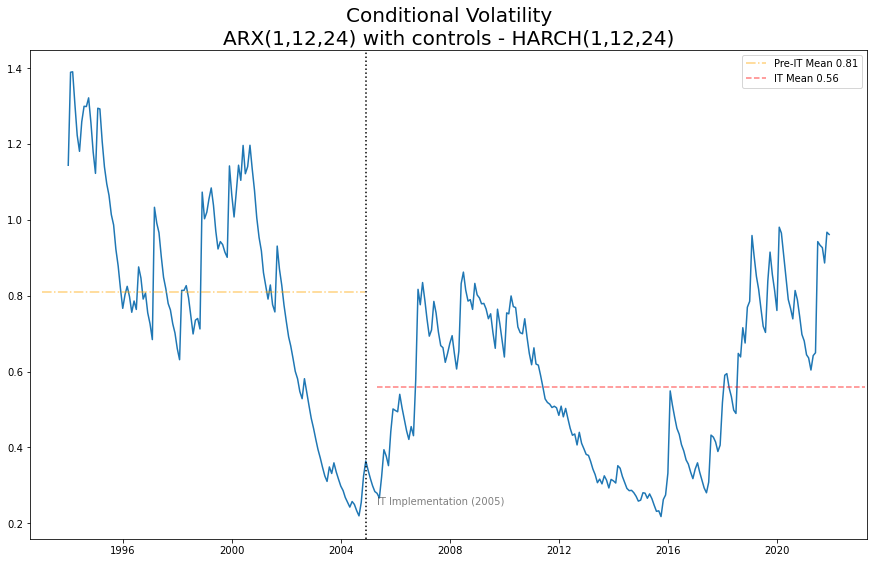

In [463]:
# pd.to_datetime(df_m.index[20])
x0 = (simdf.index.get_loc('1992-06-01'))/len(simdf.index)
x1 = (simdf.index.get_loc('2004-01-01'))/len(simdf.index)
x2 = (simdf.index.get_loc('2004-06-01'))/len(simdf.index)
x3 = (simdf.index.get_loc('2021-12-01'))/len(simdf.index)
plt.figure(figsize=(15,9))
# plt.plot(res2.conditional_volatility, label='GARCH(1,1)')
plt.plot(res3.conditional_volatility)#, label='GARCH(1,1) with ARX(1,12) and controls')
# res2.conditional_volatility.rolling(24).mean().plot(figsize=(15,9))
plt.title('Conditional Volatility\nARX(1,12,24) with controls - HARCH(1,12,24)', fontsize=20)
plt.axvline(x=pd.to_datetime('2004-12-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.25, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMean2bc, color='orange', alpha = 0.5, linestyle='-.', label='Pre-IT Mean {:.2f}'.format(PreVolMean2bc))
plt.axhline(xmin=x2, xmax=x3, y=ITVolMean2bc, color='r', alpha = 0.5, linestyle='--', label='IT Mean {:.2f}'.format(ITVolMean2bc))
plt.legend()